<a href="https://colab.research.google.com/github/gvarnavi/generative-art-iap/blob/master/01.16-Thursday/01_oscillator-systems-solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physical Systems - Oscillators

As we gradually relax the discrete properties of our physical systems to continuous ones, the next model we will look at is the two-dimensional **Kuramoto model** of interacting oscillators. This is a system designed to model synchronization, such as of circadian systems of plants and animals.
![cell_vs_osc](https://drive.google.com/uc?id=1g-qXjj4_XB5YtwBakklxHcERaO1amngy)

Much like the cells in our cellular automata, here we consider a lattice of oscillators which interact with one another. However, rather than assigning a binary state, 0 or 1, each oscillator carries a continuous state - a *phase* - which varies from $0$ to $2\pi$. These phases evolve continuously in time, governed by an ordinary differential equation (ODE) which prescribes their evolution based on nearest-neighbor interactions.

First, let's import some necessary packages.



In [0]:
%matplotlib inline
import numpy as np
from numba import jit # enables compiling for speedup
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import Normalize
import time

Before we delve into the mathematical model, let's write a routine to initialize a random lattice of such oscillators.


> **Exercise:** Implement the initialization of an $N\times N$ array of random phases on the range $[0,2\pi)$.

> Note: The ```numpy``` function ```np.random.rand(N,N)``` will return an $N\times N$ array of random numbers on the range $[0,1)$, and ```np.pi``` returns the value of $\pi$.

In [0]:
def init_lattice(N, seed):
    '''Initialize an NxN lattice of oscillators with random phases.'''
    # set random seed.
    np.random.seed(seed)
    
    lat = 2*np.pi*np.random.rand(N,N)
    return lat

Next, we define our helper functions for plotting the lattice.

In [0]:
import matplotlib.animation as animation
from IPython.display import HTML

# calculate RGB colors from a matplotlib colormap.
def get_colors(theta, colormap):
    '''
    Map an array of periodic values (0 to 2*pi) to RGBA color channels of a matplotlib colormap.
    theta - the array of values.
    colormap - the name of the colormap to use.
    '''
    theta = np.mod(theta, 2*np.pi)                            # shift all theta to lie on [0,2*pi], since values are cyclic.
    norm = Normalize(vmin=0.,vmax=2*np.pi)                    # set the color range from [0,2*pi]
    cmap = plt.get_cmap(colormap)                             # get the colormap object
    colors = cmap(norm(theta))                                # evaluate the colormap to get color channels (RGBA)
    colors[..., -1] = 0.8                                     # change the opacity
    return colors

# Plot a single snapshot of the lattice.
def plot_lattice(theta, colormap='hsv'):
    '''
    Plot a lattice of oscillators (phases) as a color image.
    theta - the array of oscillator phases.
    colormap - an optional specification for a colormap to use.
    '''
    fig, ax = plt.subplots(1,1,figsize=(6,6))                 # initialize figure
    colors = get_colors(theta, colormap)                      # get colors associated with each theta value
    im = ax.imshow(colors, extent=[-1, 1, -1, 1])             # plot the colors
    ax.tick_params(labelsize=14)                              # axis settings
    ax.set_xlim(-1,1); ax.set_ylim(-1,1)
    ax.axis('off'); ax.grid(False)
    return fig, ax, im

# Tile 6 snapshots from a simulation of the oscillators.
def tile_lattice(N, sol, colormap='hsv'):
    '''
    Tile 6 snapshots of a simulation into one figure.
    N - the size of the lattice in each dimension.
    sol - the solution object returned by the ODE solver.
    colormap - an optional specification for a colormap to use.
    '''
    fig, axes = plt.subplots(2,3,figsize=(12,8))
    step = sol.y.shape[1]//6
    for i, ax in enumerate(axes.flat):
        theta = sol.y[:,i*step].reshape(N,N)
        colors = get_colors(theta, colormap)
        ax.imshow(colors, extent=[-1, 1, -1, 1])
        ax.tick_params(labelsize=14)
        ax.set_xlim(-1,1); ax.set_ylim(-1,1)
        ax.axis('off')
        ax.grid(False)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

# generate a sequence of plots assembled into an animation.
def animate_lattice(N, sol, colormap='hsv'):
    '''
    Animate the oscillator system.
    N - the size of the lattice in each dimension.
    sol - the solution object returned by the ODE solver.
    colormap - an optional specification for a colormap to use.
    '''
    frames = sol.y.shape[1]
    theta = sol.y[:,0].reshape(N,N)
    fig, ax, im = plot_lattice(theta, colormap)

    def animate(i):
        '''Plot updates for animation.'''
        theta = sol.y[:,i].reshape(N,N)
        colors = get_colors(theta, colormap)
        im.set_data(colors)
        return im,

    ani = animation.FuncAnimation(fig, animate, frames=frames, interval=50, blit=True)
    plt.close(fig)
    return ani

Let's create a system of $100\times 100$ oscillators.

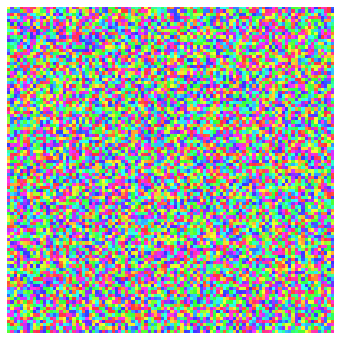

In [4]:
# lattice size
N = 100

# random seed
seed = 12

# generate the random lattice
lat = init_lattice(N, seed)

# plot snapshot
fig, ax, im = plot_lattice(lat)
plt.show()

The differential equation which governs the evolution of each oscillator's phase $\theta_i$ is given by

$$
\frac{d\theta_i}{dt} = \omega + K\sum_{j\in N(i)}\sin(\theta_j-\theta_i)
$$

where the sum is performed over all oscillators $j$ in the neighborhood $N(i)$ of oscillator $i$. Here, $\omega$ is a constant angular velocity, and $K$ a coupling strength between neighbors. We would like to define a function which takes as its input $t$, all $\theta$, $\omega$, and $K$, and returns an array $d\theta/dt$. Since the ODE involves a sum over discrete neighbors, it should appear similar to the update rule for cellular automata. As a result, we can try to use discrete convolution to perform this sum.

However, in its current form, $\sum_{j\in N(i)}\sin(\theta_j-\theta_i)$ cannot be carried out by convolution, since $\theta_j$ is coupled with $\theta_i$ in a nonlinear function. What can we do?

When in doubt, apply a trigonometric identity! Let's use

$$
\sin(\alpha-\beta) = \sin(\alpha)\cos(\beta) - \cos(\alpha)\sin(\beta)
$$

to rewrite the above expression to

$$
\sum_{j\in N(i)}\sin(\theta_j-\theta_i) = \cos(\theta_i)\sum_{j\in N(i)}\sin(\theta_j) - \sin(\theta_i)\sum_{j\in N(i)}\cos(\theta_j)
$$

recognizing that $\theta_i$ is a constant with respect to the sum and may be pulled out. This looks a lot better suited for convolution! While each of our two sums is not linear in $\theta_i$ and $\theta_j$, it *is* linear in their individual trigonometric transformations $\sin(\theta_i)$ and $\sin(\theta_j)$ (and $\cos(\theta_i)$ and $\cos(\theta_j)$).

We'll make one small extension to our ODE by introducing a constant phase shift $\alpha$ between $\theta_i$ and $\theta_j$:

$$
\frac{d\theta_i}{dt} = \omega + K\sum_{j\in N(i)}\sin(\theta_j-\theta_i - \alpha)
$$

By grouping $\theta_i$ and $\alpha$ together, we can write this directly in our expression suited for convolution:
$$
\sum_{j\in N(i)}\sin(\theta_j-\theta_i-\alpha) = \cos(\theta_i+\alpha)\sum_{j\in N(i)}\sin(\theta_j) - \sin(\theta_i+\alpha)\sum_{j\in N(i)}\cos(\theta_j)
$$

Putting everything together,
$$
\frac{d\theta_i}{dt}
= \omega + K\cos(\theta_i+\alpha)\sum_{j\in N(i)}\sin(\theta_j) - K\sin(\theta_i+\alpha)\sum_{j\in N(i)}\cos(\theta_j)
$$

We implement the ODE in the function ```kuramoto``` below using a von Neumann neighborhood of range $r=2$, which corresponds to the convolution kernel

$$
\begin{bmatrix}
0 & 0 & 1 & 0 & 0 \\
0 & 1 & 1 & 1 & 0 \\
1 & 1 & 0 & 1 & 1 \\
0 & 1 & 1 & 1 & 0 \\
0 & 0 & 1 & 0 & 0 
\end{bmatrix}
$$

Notice that the center cell is zero, as only the neighbors contribute to the sum.

In [0]:
from scipy.signal import convolve2d

def kuramoto(t, theta, N, v, K, a):
    '''ODE for the Kuramoto oscillator system.
        t - the current time.
        theta - a *linear* array of oscillator phases (linear for compatibility with solver).
        N - the system size in each dimension.
        v - the constant angular velocity.
        K - the coupling strength.
        a - the phase shift.
    '''
    theta = theta.reshape(N,N)          # reshape into square format for convolution.

    kernel = np.array([[0,0,1,0,0],     # define the convolution kernel with a radius of 2, with ones 
                       [0,1,1,1,0],     # in all neighbor positions and zero in the center.
                       [1,1,0,1,1],
                       [0,1,1,1,0],
                       [0,0,1,0,0]])
    
    sint = np.sin(theta)            
    cost = np.cos(theta)
    sum_sint = convolve2d(sint, kernel,
                         mode = 'same',
                         boundary = 'wrap') # periodic boundaries
    sum_cost = convolve2d(cost, kernel,
                         mode = 'same',
                         boundary = 'wrap') # periodic boundaries

    dtheta = v + K*np.cos(theta + a)*sum_sint - K*np.sin(theta + a)*sum_cost
    return dtheta.ravel() # ravel back to linear form for solver.

The wrapper function ```solve``` below will take our ODE function as input along with specifications for the start and end integration time, the number of evenly spaced outputs to produce along the way, the initial conditions, and any model parameters.

In [0]:
def solve(fun, ti, tf, nt, qi, args, rtol=1e-6, atol=1e-6):
    '''
    fun - the function to integrate
    ti, tf - starting and ending integration times.
    nt - number of equally spaced output points on [ti, tf].
    qi - initial conditions [x, y, th].
    args - tuple of model parameters (J, K).
    rtol, atol - tolerance for tuning the accuracy of the solver.
    '''
    t_span = [ti, tf]                   # integration range
    t_eval = np.linspace(ti, tf, nt)    # evaluation points
    t1 = time.time()
    
    # integrate the differential equation using scipy.integrate.solve_ivp
    sol = solve_ivp(lambda t, y: fun(t,y,*args), t_span, np.hstack(qi), t_eval=t_eval,
                    rtol=rtol, atol=atol)
    t2 = time.time()
    
    #print("Elapsed time: %2.2f seconds."%((t2-t1)))
    return sol

Below, we'll use the widget to test varying the phase shift between oscillators.

In [7]:
import ipywidgets as widgets
from IPython.display import display

phase_slider = widgets.FloatSlider(
    value=0., min=0.0, max=3.2, step=0.1,
    description='Phase shift:', readout_format='.1f',)

@widgets.interact_manual(a = phase_slider,
                         colormap = ['hsv','twilight','magma','rainbow','flag'])
def interactive_slider_plot(a = 0., colormap='hsv'):
    plt.close()
    v = 0.5; K = 0.2; N = 80
    lat = init_lattice(N, seed=12)
    frames = 6
    sol = solve(kuramoto, 0, 50, frames, lat.ravel(), args = (N, v, K, a))
    tile_lattice(N, sol, colormap)
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='Phase shift:', max=3.2, readout_format='.1f'), Dropd…

Below, we can define the phase shift manually and run the cell to make a movie.

In [8]:
# adjust the phase shift and colormap
a = 0.6
colormap = 'twilight'

# *** setup and movie-making ***
# lattice size, random seed, and fixed model parameters.
N = 100; seed = 12; v = 0.5; K = 0.2

# generate the random lattice
lat = init_lattice(N, seed)

# run simulation
frames = 150
sol = solve(kuramoto, 0, 20, frames, lat.ravel(), args = (N, v, K, a))

# create animation
ani = animate_lattice(N, sol, colormap)

# Display the animation
HTML(ani.to_html5_video())

Next, we will consider what happens if we allow our oscillators to move freely in space. Such systems exhibit *spatial* self-organization, much like swarms of insects or flocks of birds. The example presented here is based on the following paper: 

> O’Keeffe, K.P., Hong, H. & Strogatz, S.H. Oscillators that sync and swarm. Nat Commun 8, 1504 (2017) doi:10.1038/s41467-017-01190-3 https://www.nature.com/articles/s41467-017-01190-3.

![cell_vs_swarm](https://drive.google.com/uc?id=1zMMT_zRqTRHocBSRPKDLQ62BO88VfmXn)

Not only are the oscillators free to move continuously in 2D space, their interactions are no longer limited to nearest neighbors, but are long-ranged. Still maintaining the notion of continuous states - or phases - of each oscillator, we will see that this model system has interesting analogues to the concept of phases and phase separation in physics. Finally, due to these oscillators' collective swarm-like behavior brought about by long-ranged interactions, and the oscillatory nature of their internal states, the authors name such agents "swarmalators."

In [0]:
# define a custom plotting function which plots swarmalator positions x and y, and colors agents by their phase.
def plot_swarm(x, y, theta, colormap='hsv'):
    '''
    Plot swarmalators in 2D with phase represented by color.
    x - the x-coordinates of the swarmalators.
    y - the y-coordinates of the swarmalators.
    theta - the phases of the swarmalators.
    colormap - an optional specification for a colormap to use.
    '''
    fig, ax = plt.subplots(1,1,figsize=(7,7))
    scat = ax.scatter(x, y, color=get_colors(theta, colormap))
    ax.tick_params(labelsize=14)
    ax.set_xlim(-2,2); ax.set_ylim(-2,2)
    ax.grid(False)
    return fig, ax, scat

# tile 6 snapshots of a simulation into one figure.
def tile_swarm(N, sol, colormap='hsv'):
    '''
    Tile 6 snapshots of a simulation into one figure.
    N - the number of swarmalators.
    sol - the solution object returned by the ODE solver.
    colormap - an optional specification for a colormap to use.
    '''
    fig, axes = plt.subplots(2,3,figsize=(12,8))
    step = sol.y.shape[1]//6
    for i, ax in enumerate(axes.flat):
        x, y, theta = sol.y[:N,i*step], sol.y[N:2*N,i*step], sol.y[2*N:,i*step]
        scat = ax.scatter(x, y, color=get_colors(theta, colormap), s=10)
        ax.tick_params(labelsize=0)
        ax.set_xlim(-2,2); ax.set_ylim(-2,2)
        ax.set_xticks([]); ax.set_yticks([])
        ax.grid(False)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

# generate a sequence of plots assembled into an animation.
def animate_swarm(N, sol, colormap='hsv'):
    '''
    Animate the swarmalator system.
    N - the number of swarmalators.
    sol - the solution object returned by the ODE solver.
    colormap - an optional specification for a colormap to use.
    '''
    frames = sol.y.shape[1]
    x, y, theta = sol.y[:N,0], sol.y[N:2*N,0], sol.y[2*N:,0]
    fig, ax, scat = plot_swarm(x, y, theta, colormap)

    def animate(i):
        '''Plot updates for animation.'''
        x, y, theta = sol.y[:N,i], sol.y[N:2*N,i], sol.y[2*N:,i]
        scat.set_offsets(np.hstack([x,y]).reshape(2,-1).T)
        colors = get_colors(theta, colormap)
        scat._facecolors = colors
        scat._edgecolors = colors
        return scat,

    ani = animation.FuncAnimation(fig, animate, frames=frames, interval=50, blit=True)
    plt.close(fig)
    return ani

Before we delve into the mathematical details of the model, once again let's start by writing a function to randomly initialize our swarmalator positions and phases. Below is the framework for our initialization function. We'd like to initialize our swarmalators uniformly on the square $x\in[-1,1],y\in[-1,1]$. Also, we'd like to randomly assign each agent a phase on $[0,2\pi)$.


> **Exercise:** Implement the initialization of $x$, $y$, and phase for $N$ swarmalators.
> Note:```np.random.rand(N)``` generates $N$ random values on $[0,1)$.






In [0]:
def init_swarm(N, seed):
    '''Initialize N swarmalators randomly on [-1,1]x[-1,1] with random phases.'''
    # set random seed.
    np.random.seed(seed)
    
    x = 2*np.random.rand(N) - 1
    y = 2*np.random.rand(N) - 1
    phase = 2*np.pi*np.random.rand(N)
    return x, y, phase

Now, let's visualize a initial population $N=400$.

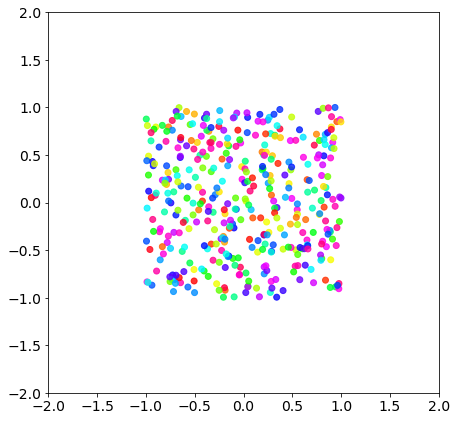

In [11]:
# number of swarmalators
N = 400

# random seed
seed = 12

x, y, theta = init_swarm(N, seed)

# plot initial snapshot
fig, ax, scat = plot_swarm(x, y, theta)
plt.show()

The evolution of the swarmalators in time is governed by a set of ordinary ODEs which prescribe the agent's motion in space in addition to the phase evolution as before. We'll consider a particular case of the model, where the system of ODEs is given by

$$
\begin{align}
\frac{dx_i}{dt} &= \frac{1}{N}\sum_{j\neq{i}}^N\Bigg(\frac{x_j-x_i}{r_{ij}}(1 + J\cos(\theta_j-\theta_i)) - \frac{x_j-x_i}{r^2_{ij}}\Bigg) \\
\frac{dy_i}{dt} &= \frac{1}{N}\sum_{j\neq{i}}^N\Bigg(\frac{y_j-y_i}{r_{ij}}(1 + J\cos(\theta_j-\theta_i)) - \frac{y_j-y_i}{r_{ij}^2}\Bigg) \\
\frac{d\theta_i}{dt} &= \frac{K}{N}\sum_{j\neq{i}}^N\frac{\sin(\theta_j-\theta_i)}{r_{ij}}
\end{align}
$$

$N$ is the total number of swarmalators, $r_{ij} = \sqrt{(x_j-x_i)^2+(y_j-y_i)^2}$ is the distance between two swarmalators, and $J$ and $K$ model parameters. $J$ tunes the influence of phase on spatial proximity, while $K$ adjusts the phase interaction. Let's define this ODE in the function ```swarmalator``` below.

In [0]:
@jit
def swarmalator(t, q, N, J, K):
    '''ODE for the swarmalator system.
        t - the current time.
        q - an array of the current x, y, and theta.
        N - the number of swarmalators.
        J - coupling constant; influence of phase on spatial rearrangement.
        K - coupling constant; phase-phase interaction.
    '''
    x, y, theta = q[:N], q[N:2*N], q[2*N:] # unpack the x-coordinates, y-coordinates, and phases
    
    # set up arrays to store the derivatives of each degree of freedom.
    dx, dy, dtheta = np.zeros(N), np.zeros(N), np.zeros(N)

    for i in range(N):
        for j in range(i+1,N):
            # compute recurring quantities for easy reuse.
            xij = x[j] - x[i]                   # x_j - x_i
            yij = y[j] - y[i]                   # y_j - y_i
            tij = theta[j] - theta[i]           # theta_j - theta_i
            rij = np.sqrt(xij*xij + yij*yij)    # r_ij - distance between agents

            # spatial attraction - x and y components
            x_att = xij/rij*(1 + J*np.cos(tij))
            y_att = yij/rij*(1 + J*np.cos(tij))

            # spatial repulsion - x and y components
            x_rep = - xij/rij**2
            y_rep = - yij/rij**2

            # phase coupling
            th_cou = K*np.sin(tij)/rij
            
            # add contributions to the derivative arrays.
            dx[i] += x_att + x_rep; dy[i] += y_att + y_rep; dtheta[i] += th_cou
            dx[j] -= x_att + x_rep; dy[j] -= y_att + y_rep; dtheta[j] -= th_cou

    # unify results into a single array, and normalize by the number of agents.
    dq = np.zeros(3*N)
    dq[:N], dq[N:2*N], dq[-N:] = dx/float(N), dy/float(N), dtheta/float(N)
    return dq

The first term in the expressions for $dx_i/dt$ and $dy_i/dt$ captures the spatially attractive interaction between swarmalators, and the second term a repulsive one. What are some preliminary conclusions we can draw about the model based on these equations?

In the first example, let's look at the case where the influence of phase on spatial movement is weak; i.e. $J$ is small. The spatial attrative force will outweigh the repulsive one except at short distances, so we expect our system to form a cohesive cluster. We simulate our system of $N=400$ swarmalators from $t=0$ to $t=30$, outputting evenly spaced snapshots along the way. We can repurpose our ```solve``` routine by plugging in ```swarmalator``` instead of ```kuramoto```.

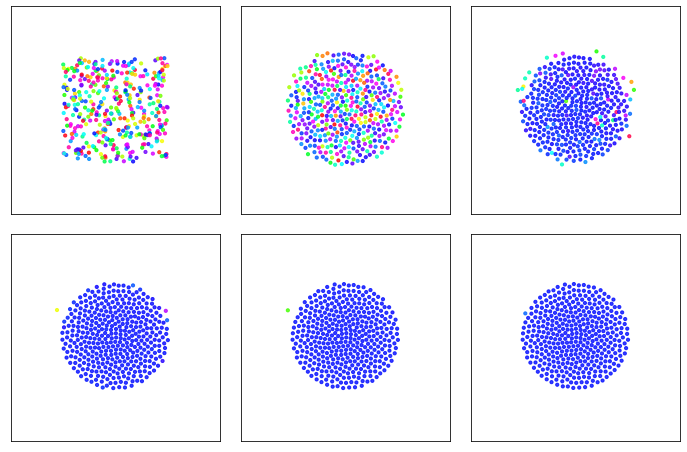

In [13]:
# set coefficients
J = 0.1
K = 0.5

# run simulation
frames = 150
sol = solve(swarmalator, 0, 30, frames, [x, y, theta], args = (N, J, K))

# plot
tile_swarm(N, sol)

The swarmalators cluster and synchronize into a single phase! Next, let's observe what happens if we make $K$ negative.

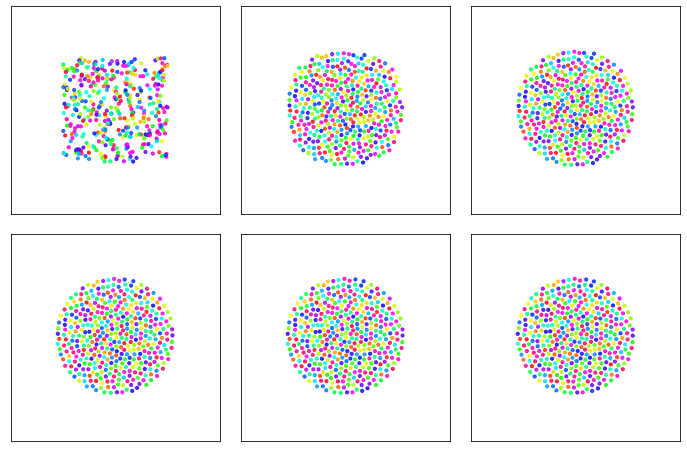

In [14]:
J = 0.1
K = -0.5

# re-initialize randomly
x, y, theta = init_swarm(N, seed)

# run simulation
frames = 150
sol = solve(swarmalator, 0, 20, frames, [x, y, theta], args = (N, J, K))

# plot
tile_swarm(N, sol)

While we still have a cohesive cluster, the swarmalators resist synchronization. How can we understand this from the model equations?

$$
\begin{align}
\frac{dx_i}{dt} &= \frac{1}{N}\sum_{j\neq{i}}^N\Bigg(\frac{x_j-x_i}{r_{ij}}(1 + J\cos(\theta_j-\theta_i)) - \frac{x_j-x_i}{r^2_{ij}}\Bigg) \\
\frac{dy_i}{dt} &= \frac{1}{N}\sum_{j\neq{i}}^N\Bigg(\frac{y_j-y_i}{r_{ij}}(1 + J\cos(\theta_j-\theta_i)) - \frac{y_j-y_i}{r_{ij}^2}\Bigg) \\
\frac{d\theta_i}{dt} &= \frac{K}{N}\sum_{j\neq{i}}^N\frac{\sin(\theta_j-\theta_i)}{r_{ij}}
\end{align}
$$

Consider two swarmalators with nearby phases $\theta_i$ and $\theta_j$. When $K$ is positive, $\theta_i$ and $\theta_j$ strive to minimize their difference, favoring synchronization. If $K$ is negative, $\theta_i$ and $\theta_j$ strive to maximize their difference.

Now let's explore the regime of strong spatial effects of phase. For positive $J$, spatial proximity of *like* phases is favored, and thus swarmalators of similar phases should rearrange near each other. To start, let's set $K=0$; that is, phases remain fixed throughout, influencing only the spatial arrangement.

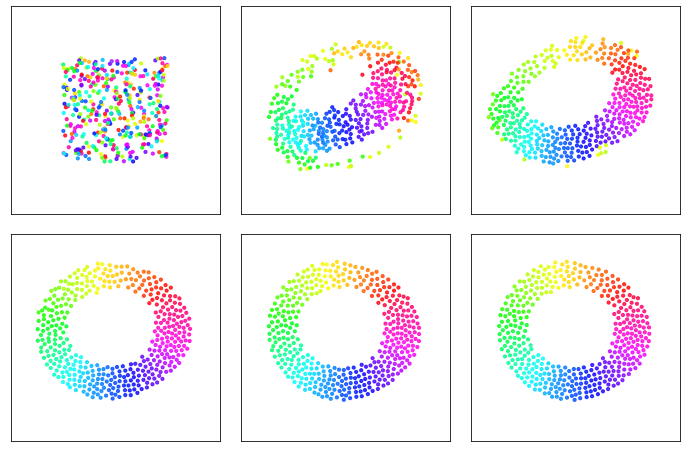

In [15]:
J = 1.
K = 0.

# re-initialize randomly
x, y, theta = init_swarm(N, seed)

# run simulation
frames = 150
sol = solve(swarmalator, 0, 80, frames, [x, y, theta], args = (N, J, K))

# plot
tile_swarm(N, sol)

The swarmalators quickly arrange to position like phases together!

If $K$ is positive, we can expect the effects of spatial rearrangement and phase alignment to create a positive feedback loop, which should lead to a uniform phase as we saw in our first example.

However if $K$ is negative, our intuition may not be as clear. Let's slightly perturb $K$ in the negative direction.

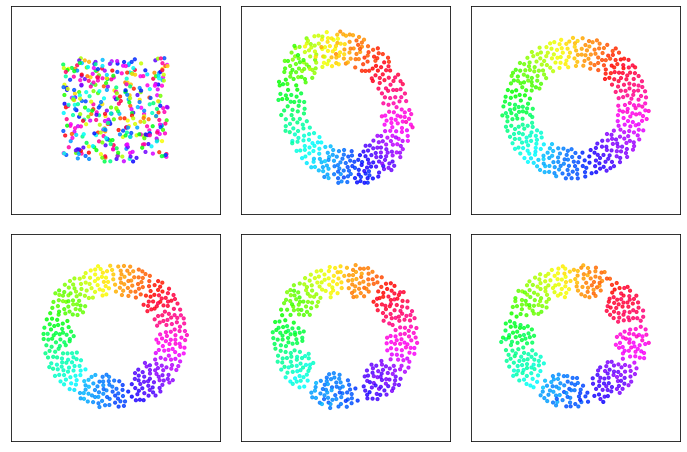

In [16]:
J = 1
K = -0.2

# re-initialize randomly
x, y, theta = init_swarm(N, seed)

# run simulation
frames = 150
sol = solve(swarmalator, 0, 150, frames, [x, y, theta], args = (N, J, K))

# plot
tile_swarm(N, sol)

This system does not stabilize, but remains in an active state throughout. Let's visualize this with an animation:

In [17]:
# create animation
ani = animate_swarm(N, sol)

# Display the animation
HTML(ani.to_html5_video())

Finally, let's amplify the negative coupling of phases to $K=-0.5$. Warning: This parameter set may take about a minute to complete.

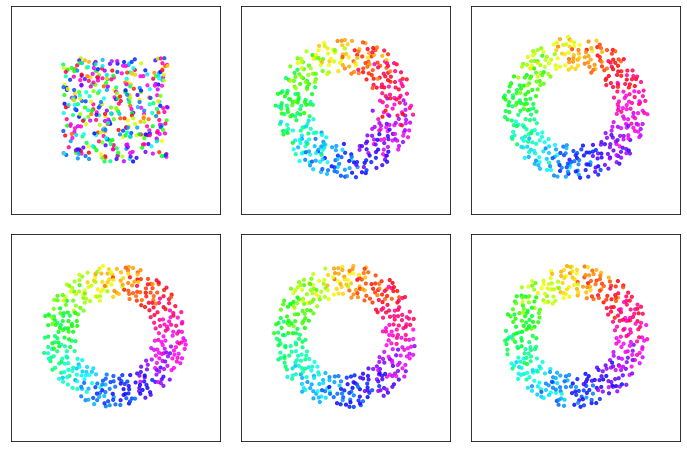

In [18]:
J = 1
K = -0.5

# re-initialize randomly
x, y, theta = init_swarm(N, seed)

# run simulation
frames = 150
sol = solve(swarmalator, 0, 150, frames, [x, y, theta], args = (N, J, K))

# plot
tile_swarm(N, sol)

In [19]:
# create animation
ani = animate_swarm(N, sol)

# Display the animation
HTML(ani.to_html5_video())